Este agarra los audio segments de audio_segments/, los procesa, y carga los spectrograms finales a spect/

In [1]:
import os, sys
import pandas as pd
from PIL import Image

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils import util

c:\Users\manue\miniconda3\envs\birds\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def create_spectrograms_from_segments(segments, spectrogram_dir, output_csv_path, 
                                    test_audios_dir=None, mels=224, hoplen=512, 
                                    nfft=2048, noise_reduce=True):
    """
    Create spectrograms from extracted audio segments.
    
    Args:
        segments (list): List of segment dictionaries from extract_audio_segments
        spectrogram_dir (str): Directory to save spectrogram images
        output_csv_path (str): Path to save the output CSV
        test_audios_dir (str, optional): Directory to save test audio samples
        mels (int): Number of mel bands for spectrogram
        hoplen (int): Hop length for spectrogram
        nfft (int): FFT window size
        noise_reduce (bool): Whether to apply noise reduction
        
    Returns:
        pd.DataFrame: DataFrame with spectrogram metadata
    """
    print(f"Creating spectrograms from {len(segments)} segments...")
    
    os.makedirs(spectrogram_dir, exist_ok=True)
    if test_audios_dir:
        os.makedirs(test_audios_dir, exist_ok=True)
    
    spectrogram_records = []
    saved_test_audios = 0
    
    for i, segment_info in enumerate(segments):
        # Apply noise reduction if requested
        if noise_reduce:
            segment_info['audio_data'] = util.reduce_noise_seg(
                segment_info['audio_data'], 
                srate=segment_info['sr'], 
                filename=segment_info['original_filename'], 
                class_id=segment_info['class_id']
            )
        
        # Create spectrogram
        record = util.create_single_spectrogram(segment_info, spectrogram_dir, mels, hoplen, nfft)
        
        if record is not None:
            # Save test audio if requested (first 10 only)
            if test_audios_dir and saved_test_audios < 10:
                util.save_test_audio(segment_info, test_audios_dir)
                saved_test_audios += 1
            
            spectrogram_records.append(record)
    
    # Create and save final DataFrame
    final_df = pd.DataFrame(spectrogram_records)
    final_df.to_csv(output_csv_path, index=False)
    
    util.plot_summary(final_df, output_csv_path)
    return final_df

In [3]:
# Define Paths
# Input: Audio segments from AudioExtracting notebook
segments_dir = os.path.join('..', 'database', 'audio_segments')
segments_csv_path = os.path.join('..', 'database', 'meta', 'audio_segments.csv')

# Output: Spectrograms and metadata
spect_dir = os.path.join('..', 'database', 'spect')
output_csv = os.path.join('..', 'database', 'meta', 'final_spects.csv')
test_audios_dir = os.path.join('..', 'database', 'test_audios')

In [4]:
# Preview files in segments_dir
print(f"Checking directory: {segments_dir}")
if os.path.exists(segments_dir):
    files = os.listdir(segments_dir)
    print(f"Total files in segments_dir: {len(files)}")
    print("\nFirst 10 files:")
    for file in files[:10]:
        print(f"  {file}")
    if len(files) > 10:
        print("  ...")
else:
    print("Directory does not exist!")

Checking directory: ..\database\audio_segments
Total files in segments_dir: 2987

First 10 files:
  XC112710_0.wav
  XC112710_1.wav
  XC112710_2.wav
  XC112712_0.wav
  XC112712_1.wav
  XC112712_10.wav
  XC112712_11.wav
  XC112712_12.wav
  XC112712_13.wav
  XC112712_14.wav
  ...


In [5]:
import importlib
importlib.reload(util)

print("Loading audio segments from disk...")
segments = util.load_audio_segments_from_disk(segments_csv_path, segments_dir, sr=32000)

if not segments:
    print("No segments loaded! Make sure AudioExtracting notebook has been run first.")
else:
    print(f"Loaded {len(segments)} segments from disk")
    print(f"First segment keys: {list(segments[0].keys())}")

Loading audio segments from disk...
Loaded 2987 audio segments from disk
Loaded 2987 segments from disk
First segment keys: ['audio_data', 'class_id', 'author', 'original_filename', 'segment_index', 'sr', 'class_total_segments']


Resetting ..\database\spect directory...
Resetting ..\database\test_audios directory...
Creating spectrograms from loaded segments...
Creating spectrograms from 2987 segments...


c:\Users\manue\miniconda3\envs\birds\Lib\site-packages\noisereduce\spectralgate\nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth


Error creating spectrogram for segment 0 of XC590621.wav: Audio buffer is not finite everywhere
Error creating spectrogram for segment 1 of XC590621.wav: Audio buffer is not finite everywhere


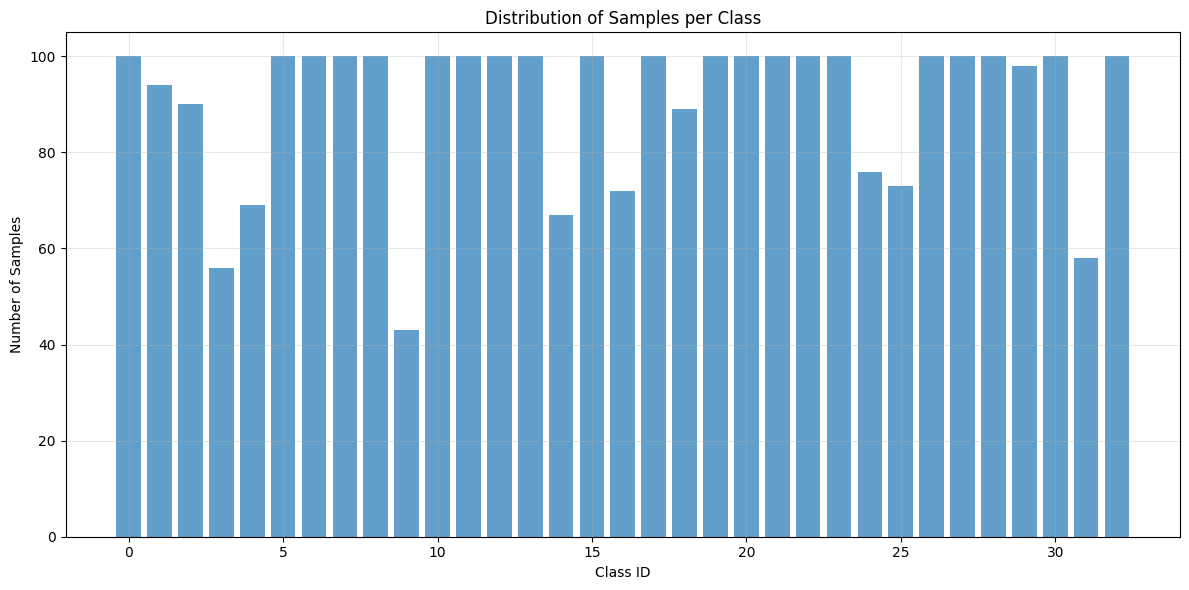

Spectrogram generation complete!


In [6]:
util.clean_dir(spect_dir)
util.clean_dir(test_audios_dir)

print("Creating spectrograms from loaded segments...")
specs = create_spectrograms_from_segments(
    segments, spect_dir, output_csv, 
    test_audios_dir=test_audios_dir, 
    mels=224, hoplen=512, nfft=2048, 
    noise_reduce=True
)

print("Spectrogram generation complete!")

Aca veo los tamaños

In [7]:
import random
amount = 20

# List all PNG files in spect_dir
spect_files = [f for f in os.listdir(spect_dir) if f.endswith('.png')]

# Fetch random images
random_files = random.sample(spect_files, min(amount, len(spect_files)))

for fname in random_files:
    img_path = os.path.join(spect_dir, fname)
    img = Image.open(img_path)
    print(f"{fname}: {img.size}")

XC573151_1_1.png: (313, 224)
XC308565_1_1.png: (313, 224)
XC419108_0_0.png: (313, 224)
XC216145_4_4.png: (313, 224)
XC503247_6_6.png: (313, 224)
XC421825_0_0.png: (313, 224)
XC506234_9_9.png: (313, 224)
XC139234_1_1.png: (313, 224)
XC527368_0_0.png: (313, 224)
XC170466_0_0.png: (313, 224)
XC157215_0_0.png: (313, 224)
XC599022_2_2.png: (313, 224)
XC489125_3_3.png: (313, 224)
XC133977_0_0.png: (313, 224)
XC387129_0_0.png: (313, 224)
XC229252_6_6.png: (313, 224)
XC460189_5_5.png: (313, 224)
XC171685_3_3.png: (313, 224)
XC545184_1_1.png: (313, 224)
XC511251_4_4.png: (313, 224)
